### Pricing Vanilla Options using an Exotic Engine
Features:
1. Able to price different payoffs (non-path dependent)
2. Supports different termination conditions (convergence, std err, path count)
3. Able to return results statistics (covergence, std err etc)
4. Easy to extend to support different simulation model (e.g. stochastic rate/vol)

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt

from ExoticEngine.Payoff import Options as O
from ExoticEngine.Statistics import Statistics as Stats
from ExoticEngine.Statistics import RandomNumberGenerators as RNG
from ExoticEngine.MonteCarloEngine import SimulationModel as Sim
from ExoticEngine.MarketDataObject import Parameter as P

from ExoticEngine import MonteCarloPricer as Pricer

In [2]:
# MC termination
condition = Stats.ConditionType("PATH_COUNT")
criteria = 200

# market observable
rate = 0.05
vol = 0.1

# option expiry
expiry = 5.0

# vanilla call/put
strike = 100.0

# double digital
lower = 50.0
upper = 100.0

In [3]:
TestRNG = RNG.TestRandom(dimension=1)

In [4]:
rate_dynamics = lambda t: rate
vol_dynamics = lambda t: vol
repo_dynamics = lambda t: 0
div_dynamics = lambda t: 0

Rate = P.Parameter(param=rate_dynamics)
Vol = P.Parameter(param=vol_dynamics)
Repo = P.Parameter(param=repo_dynamics)
Div = P.Parameter(param=div_dynamics)

Visualising GBM distribution

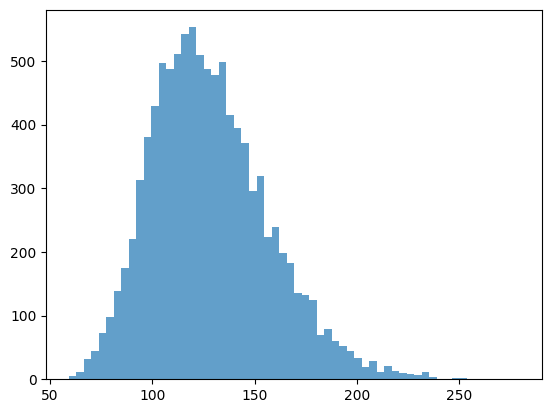

In [5]:
eq_spot = 100

S_t = []
EqModel = Sim.BSModel(eq_spot, Rate, Repo, Div, Vol, TestRNG)
for i in range(10000):
    S_t.append(EqModel.sde(0, expiry) + eq_spot)

plt.figure()
plt.hist(S_t, bins=60, alpha=0.7)
plt.show()

Pricing

In [6]:
spots = np.linspace(1.0, 150.0, 100)

call_theory = []
call_price = []
call_std_err = []

put_theory = []
put_price = []
put_std_err = []

double_digital_price = []
double_digital_std_err = []

# Vanilla Call
CallPayoff = O.PayOffCall(strike=strike)
CallOption = O.VanillaOption(CallPayoff, expiry=expiry)
for S in spots:
    EqModel = Sim.BSModel(
        spot=S, r=Rate, repo_rate=Repo, div_yield=Div, vol=Vol, RNG=TestRNG
    )
    TerminationCondition = Stats.TerminationCondition(
        condition=condition, criteria=criteria
    )
    ResultStatistics = Stats.GetStatistics(termination_condition=TerminationCondition)

    call_result = Pricer.vanilla_mc_pricer(
        option=CallOption,
        rate=Rate,
        sim_model=EqModel,
        result_collector=ResultStatistics,
    )
    call_price.append(call_result.get_mean())
    call_std_err.append(call_result.get_std_err())
    call_theory.append(Pricer.BS_CALL(S=S, K=strike, T=expiry, r=rate, sigma=vol))

# Vanilla Put
PutPayoff = O.PayOffPut(strike=strike)
PutOption = O.VanillaOption(PutPayoff, expiry=expiry)
for S in spots:
    EqModel = Sim.BSModel(
        spot=S, r=Rate, repo_rate=Repo, div_yield=Div, vol=Vol, RNG=TestRNG
    )
    TerminationCondition = Stats.TerminationCondition(
        condition=condition, criteria=criteria
    )
    ResultStatistics = Stats.GetStatistics(termination_condition=TerminationCondition)

    put_result = Pricer.vanilla_mc_pricer(
        option=PutOption,
        rate=Rate,
        sim_model=EqModel,
        result_collector=ResultStatistics,
    )
    put_price.append(put_result.get_mean())
    put_std_err.append(put_result.get_std_err())
    put_theory.append(Pricer.BS_PUT(S=S, K=strike, T=expiry, r=rate, sigma=vol))

# Double digital
DDPayoff = O.PayOffDoubleDigital(upper=upper, lower=lower)
DDOption = O.VanillaOption(DDPayoff, expiry=expiry)
for S in spots:
    EqModel = Sim.BSModel(
        spot=S, r=Rate, repo_rate=Repo, div_yield=Div, vol=Vol, RNG=TestRNG
    )
    TerminationCondition = Stats.TerminationCondition(
        condition=condition, criteria=criteria
    )
    ResultStatistics = Stats.GetStatistics(termination_condition=TerminationCondition)

    double_digital_result = Pricer.vanilla_mc_pricer(
        option=DDOption, rate=Rate, sim_model=EqModel, result_collector=ResultStatistics
    )
    double_digital_price.append(double_digital_result.get_mean())
    double_digital_std_err.append(double_digital_result.get_std_err())

Plotting

In [7]:
def plot_price_as_function_of_spot(
    spots: list[float],
    theory: list[float] | None,
    emp_prices: list[float],
    sems: list[float],
    title: str,
):
    upper_bound = [m + sems[i] for i, m in enumerate(emp_prices)]
    lower_bound = [m - sems[i] for i, m in enumerate(emp_prices)]

    plt.figure()
    plt.title(title)
    if theory:
        plt.plot(spots, theory, label="theoretical", color="gold", alpha=0.8)
    plt.plot(spots, emp_prices, label="numerical", color="royalblue")
    plt.fill_between(
        spots,
        upper_bound,
        lower_bound,
        color="skyblue",
        alpha=0.5,
        label=r"$\pm 1$ std err",
    )
    plt.xlabel("Spot")
    plt.legend()
    plt.show()

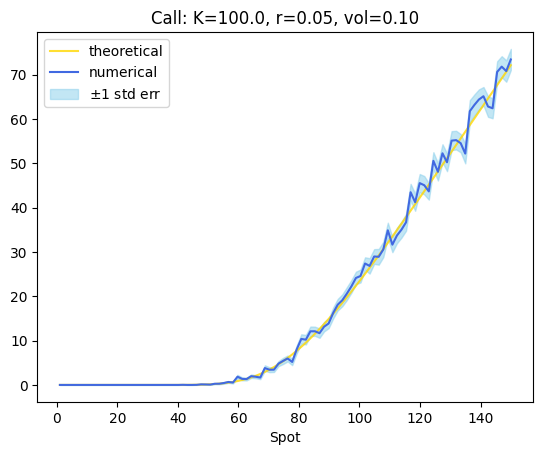

In [8]:
title = "{0}: K={1}, r={2:.2f}, vol={3:.2f}".format("Call", strike, rate, vol)
plot_price_as_function_of_spot(
    spots=spots,
    theory=call_theory,
    emp_prices=call_price,
    sems=call_std_err,
    title=title,
)

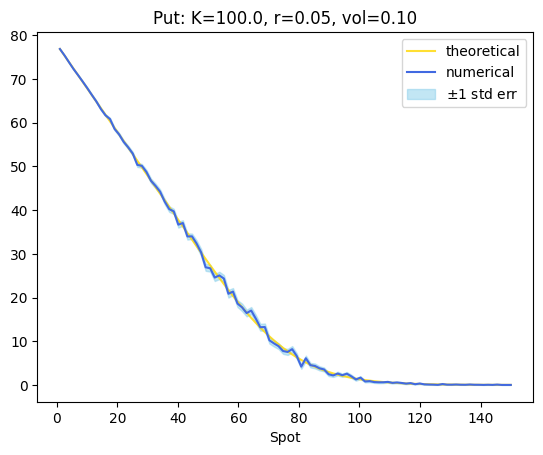

In [9]:
title = "{0}: K={1}, r={2:.2f}, vol={3:.2f}".format("Put", strike, rate, vol)
plot_price_as_function_of_spot(
    spots=spots, theory=put_theory, emp_prices=put_price, sems=put_std_err, title=title
)

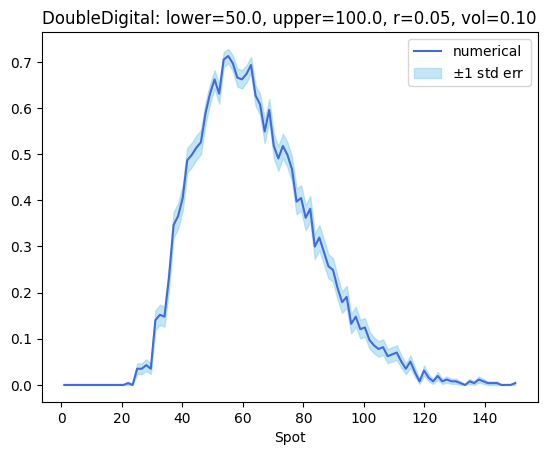

In [10]:
title = "{0}: lower={1}, upper={2}, r={3:.2f}, vol={4:.2f}".format(
    "DoubleDigital", lower, upper, rate, vol
)
plot_price_as_function_of_spot(
    spots=spots,
    theory=None,
    emp_prices=double_digital_price,
    sems=double_digital_std_err,
    title=title,
)